## Coursework 2
Objective:
(1) obtain practical knowledge and hands-on understanding of the basic concepts in Generative Adversarial Nets(GAN);
(2) obtain practical experience on how to implement basic GAN using tensorflow.

Resilting pictures are uploaded and stoared: https://drive.google.com/drive/u/0/folders/1OolcTqMCwFHpZ0rfcT7KAWnQXkkYyzRW

# 1. Understanding GAN models basic concepts
Basic material:
Some of online materials for tensorflow-code may help you better complete this coursework (if you not familiar with tensorflow, you can follow this step by step) https://www.tensorflow.org/versions/r1.1/get_started/mnist/beginners https://github.com/floydhub/tensorflow-notebooks- examples/blob/master/3_NeuralNetworks/autoencoder.ipynb

## The questions to think over:

**1. What are two basic part in generative model?**<br>
* a generative model G
* a discriminative model D 

**2. What is the specific objective of these two part?**<br>
* generative model G - captures the data distribution
* discriminative model D - estimates the probability that a sample came from the training data rather than G

**3. What is the basic loss function of GAN?**<br>
Loss function or cost function is a function that maps an event or values of one or more variables onto a real number intuitively representing some "cost" associated with the event. Need to minimize a loss function.

The discriminator(G_sample) wants the predictions on the “real” data to be all ones and the predictions on the “fake” data from the generator to be all zeros. The generator wants the discriminator’s predictions to be all ones, as per definition, we want to maximize the probability of real data.

Maximizing tf.reduce_mean(tf.log(D_fake)).

**4. What is training process of basic GAN model?**<br>
Training the GAN means Training the Generator. The generator initially produces garbage images, and the loss value is high. So, the back-propagation updates the generator’s weights to produce more realistic images as the training continues. This is how the generator is trained via training the GAN.

In [1]:
!pip install imageio --upgrade
!pip install pydrive

Requirement already up-to-date: imageio in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (from imageio)
Requirement already up-to-date: pillow in /usr/local/lib/python3.6/dist-packages (from imageio)


In [0]:
import os, time, itertools, imageio, pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# G(z)
def generator(x):
    # initializers
    w_init = tf.truncated_normal_initializer(mean=0, stddev=0.02)
    b_init = tf.constant_initializer(0.)
    # 1st hidden layer
    w0 = tf.get_variable('G_w0', [x.get_shape()[1], 128], initializer=w_init)
    b0 = tf.get_variable('G_b0', [128], initializer=b_init)
    h0 = tf.nn.relu(tf.matmul(x, w0) + b0)
    # output hidden layer
    w1 = tf.get_variable('G_w1', [h0.get_shape()[1], 784], initializer=w_init)
    b1 = tf.get_variable('G_b1', [784], initializer=b_init)
    o = tf.nn.tanh(tf.matmul(h0, w1) + b1)
    return o
    ### Code:ToDO( Change the architecture as CW2 Guidance required)

In [0]:
# D(x)
def discriminator(x, drop_out):
    # initializers
    w_init = tf.truncated_normal_initializer(mean=0, stddev=0.02)
    b_init = tf.constant_initializer(0.)
    # 1st hidden layer
    w0 = tf.get_variable('D_w0', [x.get_shape()[1], 784], initializer=w_init)
    b0 = tf.get_variable('D_b0', [784], initializer=b_init)
    h0 = tf.nn.relu(tf.matmul(x, w0) + b0)
    # output layer
    w1 = tf.get_variable('D_w1', [h0.get_shape()[1], 1], initializer=w_init)
    b1 = tf.get_variable('D_b1', [1], initializer=b_init)
    o = tf.sigmoid(tf.matmul(h0, w1) + b1)
    ###  Code: ToDO( Change the architecture as CW2 Guidance required)

    return o

In [0]:
def show_result(num_epoch, folder_id, name = 'result.png', isFix=False):
    z_ = np.random.normal(0, 1, (25, 100))

    if isFix:
        test_images = sess.run(G_z, {z: fixed_z_, drop_out: 0.0})
    else:
        test_images = sess.run(G_z, {z: z_, drop_out: 0.0})

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (28, 28)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    
    plt.savefig(name)
    file = drive.CreateFile({'title': label, "parents": [{"kind": "https://drive.google.com/drive/u/0/folders/", "id": folder_id}]})
    file.SetContentFile(name)
    file.Upload()
    
    if num_epoch == 10 or num_epoch == 20 or num_epoch == 50 or num_epoch == 100:
        plt.show()
        
    plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [11]:
# load MNIST
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_set = (mnist.train.images - 0.5) / 0.5  # normalization; range: -1 ~ 1

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
# networks : generator
with tf.variable_scope('G'):
    z = tf.placeholder(tf.float32, shape=(None, 100))
    G_z = generator(z)
# networks : discriminator
with tf.variable_scope('D') as scope:
    drop_out = tf.placeholder(dtype=tf.float32, name='drop_out')
    x = tf.placeholder(tf.float32, shape=(None, 784))
    D_real = discriminator(x, drop_out)
    scope.reuse_variables()
    D_fake = discriminator(G_z, drop_out)

In [0]:
# loss for each network
eps = 1e-2
D_loss = tf.reduce_mean(-tf.log(D_real + eps) - tf.log(1 - D_fake + eps))
G_loss = tf.reduce_mean(-tf.log(D_fake + eps))

# trainable variables for each network
t_vars = tf.trainable_variables()
D_vars = [var for var in t_vars if 'D_' in var.name]
G_vars = [var for var in t_vars if 'G_' in var.name]

In [0]:
def train_gan(batch_size, lr, train_epoch):

  train_hist = {}
  train_hist['D_losses'] = []
  train_hist['G_losses'] = []
  train_hist['per_epoch_ptimes'] = []
  train_hist['total_ptime'] = []
  
  # optimizer for each network
  D_optim = tf.train.AdamOptimizer(lr).minimize(D_loss, var_list=D_vars)
  G_optim = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list=G_vars)

  # open session and initialize all variables
  sess = tf.InteractiveSession()
  tf.global_variables_initializer().run()

  # training-loop
  np.random.seed(int(time.time()))
  start_time = time.time()
  for epoch in range(train_epoch):
      G_losses = []
      D_losses = []
      epoch_start_time = time.time()
      for iter in range(train_set.shape[0] // batch_size):
          # update discriminator
          x_ = train_set[iter*batch_size:(iter+1)*batch_size]
          z_ = np.random.normal(0, 1, (batch_size, 100))

          loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, z: z_, drop_out: 0.3})
          D_losses.append(loss_d_)

          # update generator
          z_ = np.random.normal(0, 1, (batch_size, 100))
          loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, drop_out: 0.3})
          G_losses.append(loss_g_)

      epoch_end_time = time.time()
      per_epoch_ptime = epoch_end_time - epoch_start_time
      print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))

      ### Save pictures to the Google Drive: goo.gl/VRBxHS
      p = 'MNIST_GAN_results/Random_results/MNIST_GAN_' + str(epoch + 1) + '.png'
      show_result((epoch + 1), folder_id = '1M6GR1CwY5ssylL0X39wjEkiRyakgTtaF', name=p, isFix=False)
      
      train_hist['D_losses'].append(np.mean(D_losses))
      train_hist['G_losses'].append(np.mean(G_losses))
      train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
  end_time = time.time()
  total_ptime = end_time - start_time
  train_hist['total_ptime'].append(total_ptime)
  print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
  print("Training finish!... save training results")
  with open('MNIST_GAN_results/train_hist.pkl', 'wb') as f:
      pickle.dump(train_hist, f)
  show_train_hist(train_hist, show=True)
  images = []
  sess.close()

[1/100] - ptime: 3.97 loss_d: 0.489, loss_g: 1.064
[2/100] - ptime: 3.95 loss_d: 0.178, loss_g: 2.067
[3/100] - ptime: 3.90 loss_d: 0.302, loss_g: 2.348
[4/100] - ptime: 3.98 loss_d: 0.279, loss_g: 2.583
[5/100] - ptime: 3.96 loss_d: 0.220, loss_g: 2.849
[6/100] - ptime: 3.95 loss_d: 0.254, loss_g: 2.792
[7/100] - ptime: 3.92 loss_d: 0.253, loss_g: 2.841
[8/100] - ptime: 3.95 loss_d: 0.378, loss_g: 2.285
[9/100] - ptime: 3.96 loss_d: 0.264, loss_g: 2.582
[10/100] - ptime: 3.94 loss_d: 0.385, loss_g: 2.478
[11/100] - ptime: 3.94 loss_d: 0.410, loss_g: 2.446
[12/100] - ptime: 3.95 loss_d: 0.420, loss_g: 2.267
[13/100] - ptime: 3.91 loss_d: 0.691, loss_g: 1.838
[14/100] - ptime: 3.99 loss_d: 0.822, loss_g: 1.555
[15/100] - ptime: 3.94 loss_d: 0.823, loss_g: 1.529
[16/100] - ptime: 3.98 loss_d: 0.766, loss_g: 1.652
[17/100] - ptime: 3.92 loss_d: 0.675, loss_g: 1.822
[18/100] - ptime: 3.95 loss_d: 0.698, loss_g: 1.898
[19/100] - ptime: 3.93 loss_d: 0.646, loss_g: 1.963
[20/100] - ptime: 3.9

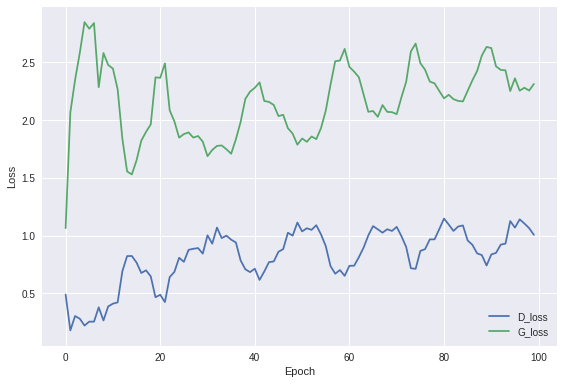

In [11]:
train_gan(batch_size = 100, lr = 0.0002, train_epoch = 100)

## The excises to conduct:

**1. Understanding the  framework.**<br>
1) Dataset: What is dataset being used? How can you load this dataset?

MNIST dataset was used
from tensorflow.examples.tutorials.mnist import input_data

2) Model: Can you plot/draw the basic architecture in this case?

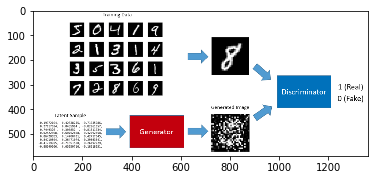

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('arch.png'))

3) Loss: What is loss function in this example?

eps = 1e-2
D_loss = tf.reduce_mean(-tf.log(D_real + eps) - tf.log(1 - D_fake + eps))
G_loss = tf.reduce_mean(-tf.log(D_fake + eps))

4) Training: How is this network being trained?

5) Test: How do you test this model?
G learns to make data that is indistiguishable from real data to the discriminator.

**2. Change the learning rate to 0.01 and train for a few epochs to understand
how learning rate will influence the model outcome.**<br>

[1/100] - ptime: 4.04 loss_d: 4.589, loss_g: -0.009
[2/100] - ptime: 3.97 loss_d: 4.595, loss_g: -0.010
[3/100] - ptime: 4.00 loss_d: 4.595, loss_g: -0.010
[4/100] - ptime: 3.97 loss_d: 4.595, loss_g: -0.010
[5/100] - ptime: 3.99 loss_d: 4.595, loss_g: -0.010
[6/100] - ptime: 3.99 loss_d: 4.595, loss_g: -0.010
[7/100] - ptime: 4.02 loss_d: 4.595, loss_g: -0.010
[8/100] - ptime: 4.02 loss_d: 4.595, loss_g: -0.010
[9/100] - ptime: 4.07 loss_d: 4.595, loss_g: -0.010
[10/100] - ptime: 4.02 loss_d: 4.595, loss_g: -0.010
[11/100] - ptime: 4.06 loss_d: 4.595, loss_g: -0.010
[12/100] - ptime: 3.96 loss_d: 4.595, loss_g: -0.010
[13/100] - ptime: 3.96 loss_d: 4.595, loss_g: -0.010
[14/100] - ptime: 4.01 loss_d: 4.595, loss_g: -0.010
[15/100] - ptime: 4.02 loss_d: 4.595, loss_g: -0.010
[16/100] - ptime: 4.02 loss_d: 4.595, loss_g: -0.010
[17/100] - ptime: 3.95 loss_d: 4.595, loss_g: -0.010
[18/100] - ptime: 4.02 loss_d: 4.595, loss_g: -0.010
[19/100] - ptime: 3.97 loss_d: 4.595, loss_g: -0.010
[2

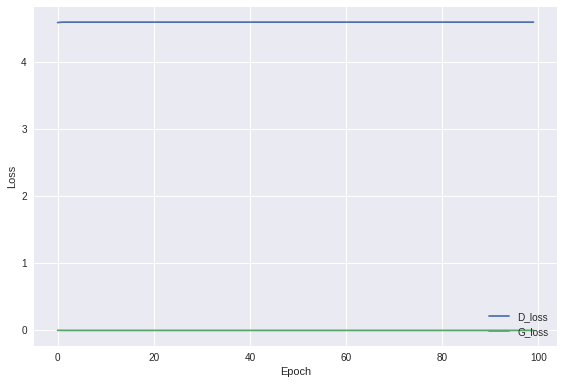

In [10]:
train_gan(batch_size = 100, lr = 0.01, train_epoch = 100)

**lr = 0.0002**

[100/100] - ptime: 3.88 loss_d: 1.006, loss_g: 2.313

Avg per epoch ptime: 3.93, total 100 epochs ptime: 392.80


**lr = 0.01:**

[100/100] - ptime: 4.00 loss_d: 4.595, loss_g: -0.010

Avg per epoch ptime: 3.99, total 100 epochs ptime: 398.72

From this experiments experiment we can conclude that having a very small loss_d doesn’t seem to be as bad as having a very small loss_g. In the second experiment loss_g is very small, the generator has learned how to consistently fool the discriminator into thinking that the fake images are more real than reality – that usually seems to mean that its exploiting a blind spot that the discriminator can’t learn to protect, or that it has found a single highly convincing sample.

As can be seen, the function changes in the wrong direction meaning that training is not proceeding correctly. After several iterations, when it is seen that algorighm is stuck on the same numbers and not improving performance, researcher should stop and reduce the learning rate. If the learning rate is small enough, there is a pretty strong guarantee that the loss function is always going in the right direction up until the point where it finds some local optimum.

The outcome mirrors a problem that does actually occur in higher-dimensional GANs. If we look at what happens to the data generated here during this malfunction, the generator is only outputting copies of the single most likely data point – the diversity of the generated set has collapsed. This kind of collapse happens in image-generation GANs as well, where if the generator gets too far ahead it just memorizes one example from the training set and only outputs that regardless of the variations in the noise source. Once the network has fallen into that hole, it’s usually very hard to recover the entropy of the outputs with further training. The usual protocol is to adjust the learning rates to keep the error of both the generator and discriminator from getting too small, but perhaps the reason why this kind of careful management is necessary is that there are true fixed points in the parameter space corresponding to this collapse, and unless those fixed points are somehow destabilized then the networks will always be at risk of going there if you continue training indefinitely. A small decay in the learning rate can help with stabilizing.

The training speed remains approximately the same.

**3. Change the batch size to 256, and discuss how the batch size influence the
model performance regarding its training speed and test accuracy.**<br>

[1/100] - ptime: 2.19 loss_d: 0.746, loss_g: 0.774
[2/100] - ptime: 2.22 loss_d: 0.433, loss_g: 1.111
[3/100] - ptime: 2.22 loss_d: 0.407, loss_g: 1.106
[4/100] - ptime: 2.22 loss_d: 0.309, loss_g: 1.590
[5/100] - ptime: 2.22 loss_d: 0.362, loss_g: 1.720
[6/100] - ptime: 2.25 loss_d: 0.363, loss_g: 2.016
[7/100] - ptime: 2.24 loss_d: 0.225, loss_g: 2.496
[8/100] - ptime: 2.24 loss_d: 0.349, loss_g: 2.091
[9/100] - ptime: 2.24 loss_d: 0.332, loss_g: 2.294
[10/100] - ptime: 2.22 loss_d: 0.315, loss_g: 2.485
[11/100] - ptime: 2.21 loss_d: 0.388, loss_g: 2.171
[12/100] - ptime: 2.23 loss_d: 0.362, loss_g: 2.296
[13/100] - ptime: 2.24 loss_d: 0.285, loss_g: 2.605
[14/100] - ptime: 2.23 loss_d: 0.203, loss_g: 2.830
[15/100] - ptime: 2.23 loss_d: 0.311, loss_g: 2.569
[16/100] - ptime: 2.23 loss_d: 0.482, loss_g: 2.133
[17/100] - ptime: 2.23 loss_d: 0.378, loss_g: 2.365
[18/100] - ptime: 2.23 loss_d: 0.464, loss_g: 2.139
[19/100] - ptime: 2.25 loss_d: 0.351, loss_g: 2.292
[20/100] - ptime: 2.2

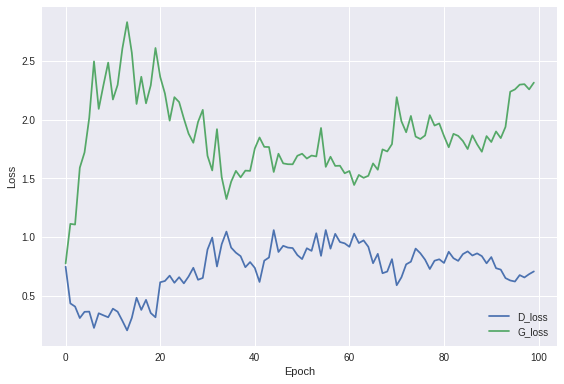

In [12]:
train_gan(batch_size = 256, lr = 0.0002, train_epoch = 100)

**lbatch_size = 100**

[100/100] - ptime: 3.88 loss_d: 1.006, loss_g: 2.313

Avg per epoch ptime: 3.93, total 100 epochs ptime: 392.80


**batch_size = 256:**

[100/100] - ptime: 2.23 loss_d: 0.706, loss_g: 2.315

Avg per epoch ptime: 2.23, total 100 epochs ptime: 222.67

Using batches size of 256, we reaches equivalent loss_g and almost the equivalent for loss_s after the same number of training epochs, leading to greater parallelism and shorter training times.

Usefull article:
https://arxiv.org/abs/1711.00489

**4. Change the training epoch to 200, run it.**<br>
Training the GAN me

[1/200] - ptime: 3.90 loss_d: 0.484, loss_g: 1.063
[2/200] - ptime: 4.00 loss_d: 0.162, loss_g: 2.196
[3/200] - ptime: 3.92 loss_d: 0.301, loss_g: 2.411
[4/200] - ptime: 3.98 loss_d: 0.338, loss_g: 2.425
[5/200] - ptime: 3.98 loss_d: 0.425, loss_g: 2.460
[6/200] - ptime: 3.99 loss_d: 0.615, loss_g: 2.046
[7/200] - ptime: 3.95 loss_d: 0.726, loss_g: 1.668
[8/200] - ptime: 3.96 loss_d: 0.575, loss_g: 1.869
[9/200] - ptime: 3.96 loss_d: 0.649, loss_g: 1.775
[10/200] - ptime: 3.96 loss_d: 0.982, loss_g: 1.547
[11/200] - ptime: 3.99 loss_d: 0.759, loss_g: 1.696
[12/200] - ptime: 3.95 loss_d: 0.806, loss_g: 1.583
[13/200] - ptime: 3.97 loss_d: 0.907, loss_g: 1.464
[14/200] - ptime: 3.97 loss_d: 0.899, loss_g: 1.447
[15/200] - ptime: 3.96 loss_d: 0.787, loss_g: 1.851
[16/200] - ptime: 3.98 loss_d: 0.774, loss_g: 1.697
[17/200] - ptime: 4.02 loss_d: 0.823, loss_g: 1.600
[18/200] - ptime: 3.95 loss_d: 0.891, loss_g: 1.483
[19/200] - ptime: 3.97 loss_d: 0.840, loss_g: 1.616
[20/200] - ptime: 3.9

[183/200] - ptime: 3.99 loss_d: 0.651, loss_g: 2.411
[184/200] - ptime: 3.97 loss_d: 0.641, loss_g: 2.421
[185/200] - ptime: 4.02 loss_d: 0.608, loss_g: 2.441
[186/200] - ptime: 4.02 loss_d: 0.605, loss_g: 2.461
[187/200] - ptime: 4.01 loss_d: 0.584, loss_g: 2.460
[188/200] - ptime: 3.99 loss_d: 0.619, loss_g: 2.477
[189/200] - ptime: 4.02 loss_d: 0.606, loss_g: 2.456
[190/200] - ptime: 3.95 loss_d: 0.590, loss_g: 2.480
[191/200] - ptime: 4.03 loss_d: 0.580, loss_g: 2.485
[192/200] - ptime: 3.99 loss_d: 0.577, loss_g: 2.475
[193/200] - ptime: 4.01 loss_d: 0.554, loss_g: 2.499
[194/200] - ptime: 3.99 loss_d: 0.564, loss_g: 2.517
[195/200] - ptime: 4.01 loss_d: 0.548, loss_g: 2.502
[196/200] - ptime: 3.95 loss_d: 0.538, loss_g: 2.521
[197/200] - ptime: 4.00 loss_d: 0.537, loss_g: 2.522
[198/200] - ptime: 4.00 loss_d: 0.532, loss_g: 2.533
[199/200] - ptime: 4.01 loss_d: 0.528, loss_g: 2.553
[200/200] - ptime: 4.01 loss_d: 0.522, loss_g: 2.533
Avg per epoch ptime: 3.99, total 200 epochs pt

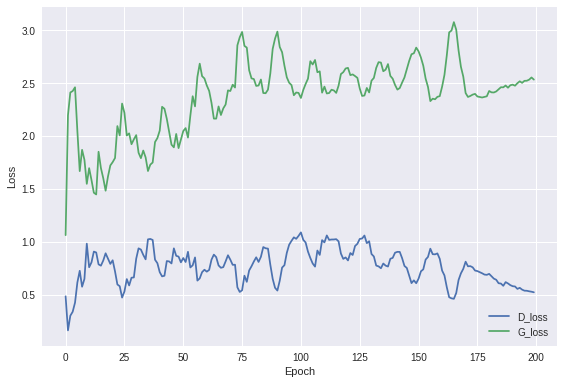

In [13]:
train_gan(batch_size = 100, lr = 0.0002, train_epoch = 200)

Feed forward + backprop = epoch

**train_epoch = 100:**

[100/100] - ptime: 3.88 loss_d: 1.006, loss_g: 2.313

Avg per epoch ptime: 3.93, total 100 epochs ptime: 392.80


**train_epoch = 200:**

[200/200] - ptime: 4.01 loss_d: 0.522, loss_g: 2.533

Avg per epoch ptime: 3.99, total 200 epochs ptime: 798.88


Loss_d has signifantly decreased, loss_g increased a little bit.

# 2. Generative Adversarial Networks with TensorFlow
Objective: To become familiar with GAN and re-implement the original GAN model. 


## The questions to think over:
**1. What is dropout in deep learning and its advantages.**<br>
  Dropout is a regularization technique for neural network, when randomly selected neurons are ignored during training. They are “dropped-out” randomly. This approach prevents neural networks from overfitting.

**2. List some typical optimizers in deep learning.**<br>
* SGD: stochastic gradient descent
* Momentum
* Nesterov Momentum
* AdaGrad
* RMSProp
* Adam: adaptive learning rate method

More about optimisation: http://www.deeplearningbook.org/contents/optimization.html

**3. What optimizer we used for training in this case.**<br>
Adam

**4. How do D-loss and G-loss change during training? Visualize how the D-loss and G-loss change during training and explain why.**<br>
* a generative model G
* a discriminative model D 

Adam is generally regarded as being fairly robust to the choice of hyper parameters, though the learning rate sometimes needs to be changed from the suggested default.

In [0]:
# G(z)
def generator2(x):
    # initializers
    w_init = tf.truncated_normal_initializer(mean=0, stddev=0.02)
    b_init = tf.constant_initializer(0.)

    # 1st hidden layer
    # x.getshape()[1] = 784 - dimentions, 28x28 size of our pics
    w0 = tf.get_variable('G_w0', [x.get_shape()[1], 256], initializer=w_init)
    b0 = tf.get_variable('G_b0', [256], initializer=b_init)
    h0 = tf.nn.leaky_relu(tf.matmul(x, w0) + b0)

    # 2d hidden layer
    # h0.get_shape()[1] = 256 - output of the 1st layer
    w1 = tf.get_variable('G_w1', [h0.get_shape()[1], 512], initializer=w_init)
    b1 = tf.get_variable('G_b1', [512], initializer=b_init)
    h1 = tf.nn.leaky_relu(tf.matmul(h0, w1) + b1)

    # 3d hidden layer
    w2 = tf.get_variable('G_w2', [h1.get_shape()[1], 1024], initializer=w_init)
    b2 = tf.get_variable('G_b2', [1024], initializer=b_init)
    h2 = tf.nn.leaky_relu(tf.matmul(h1, w2) + b2)

    # output layer
    w3 = tf.get_variable('G_w3', [h2.get_shape()[1], 784], initializer=w_init)
    b3 = tf.get_variable('G_b3', [784], initializer=b_init)
    o = tf.nn.tanh(tf.matmul(h2, w3) + b3)
    
    return o

In [0]:
# D(x)
def discriminator2(x, drop_out):
    # initializers
    w_init = tf.truncated_normal_initializer(mean=0, stddev=0.02)
    b_init = tf.constant_initializer(0.)
    
    # 1st hidden layer
    w0 = tf.get_variable('D_w0', [x.get_shape()[1], 1024], initializer=w_init)
    b0 = tf.get_variable('D_b0', [1024], initializer=b_init)
    h0 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(x, w0) + b0), drop_out)

    # 2d hidden layer
    w1 = tf.get_variable('D_w1', [h0.get_shape()[1], 512], initializer=w_init)
    b1 = tf.get_variable('D_b1', [512], initializer=b_init)
    h1 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(h0, w1) + b1), drop_out)

    # 3d hidden layer
    w2 = tf.get_variable('D_w2', [h1.get_shape()[1], 256], initializer=w_init)
    b2 = tf.get_variable('D_b2', [256], initializer=b_init)
    h2 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(h1, w2) + b2), drop_out)
    
    # output layer
    w3 = tf.get_variable('D_w3', [h2.get_shape()[1], 1], initializer=w_init)
    b3 = tf.get_variable('D_b3', [1], initializer=b_init)
    o = tf.sigmoid(tf.matmul(h2, w3) + b3)
    
    return o

In [0]:
# networks : generator
with tf.variable_scope('G'):
    z = tf.placeholder(tf.float32, shape=(None, 100))
    G_z = generator2(z)


# networks : discriminator
with tf.variable_scope('D') as scope:
    drop_out = tf.placeholder(dtype=tf.float32, name='drop_out')
    x = tf.placeholder(tf.float32, shape=(None, 784))
    x_image = tf.summary.image('input', tf.reshape(x, [-1, 28, 28, 1]), 3)
    
    D_real = discriminator2(x, drop_out)
    scope.reuse_variables()
    D_fake = discriminator2(G_z, drop_out)

In [0]:
# loss for each network 
eps = 1e-2 #(log should not be null)
D_loss = tf.reduce_mean(-tf.log(D_real + eps) - tf.log(1 - D_fake + eps))
G_loss = tf.reduce_mean(-tf.log(D_fake + eps))

# trainable variables for each network
t_vars = tf.trainable_variables()
D_vars = [var for var in t_vars if 'D_' in var.name]
G_vars = [var for var in t_vars if 'G_' in var.name]

In [0]:
# training parameters
batch_size = 100
lr = 0.0002
train_epoch = 100

# optimizer for each network
D_optim = tf.train.AdamOptimizer(lr).minimize(D_loss, var_list=D_vars)
G_optim = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list=G_vars)

# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# tf.summary.FileWriter('board_beginner',sess.graph)   # magic board  
writer = tf.summary.FileWriter('board_beginner')  # create writer
writer.add_graph(sess.graph)

[1/100] - ptime: 7.39 loss_d: 4.595, loss_g: -0.010
[2/100] - ptime: 7.44 loss_d: 4.595, loss_g: -0.010
[3/100] - ptime: 7.43 loss_d: 4.593, loss_g: -0.007
[4/100] - ptime: 7.47 loss_d: 4.524, loss_g: 0.153
[5/100] - ptime: 7.43 loss_d: 4.595, loss_g: -0.010
[6/100] - ptime: 7.64 loss_d: 3.408, loss_g: 1.325
[7/100] - ptime: 7.52 loss_d: 1.397, loss_g: 3.735
[8/100] - ptime: 7.55 loss_d: 1.630, loss_g: 3.417
[9/100] - ptime: 7.54 loss_d: 0.786, loss_g: 4.125
[10/100] - ptime: 7.52 loss_d: 0.686, loss_g: 3.481


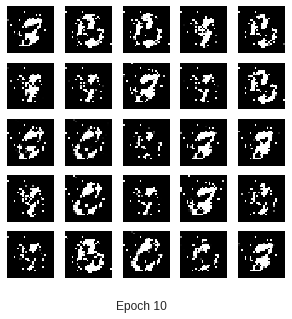

[11/100] - ptime: 7.62 loss_d: 0.587, loss_g: 2.441
[12/100] - ptime: 7.51 loss_d: 0.452, loss_g: 2.786
[13/100] - ptime: 7.50 loss_d: 0.579, loss_g: 2.350
[14/100] - ptime: 7.54 loss_d: 0.700, loss_g: 1.994
[15/100] - ptime: 7.56 loss_d: 0.759, loss_g: 1.867
[16/100] - ptime: 7.75 loss_d: 0.785, loss_g: 1.755
[17/100] - ptime: 7.50 loss_d: 0.831, loss_g: 1.686
[18/100] - ptime: 7.44 loss_d: 0.902, loss_g: 1.516
[19/100] - ptime: 7.39 loss_d: 0.930, loss_g: 1.438
[20/100] - ptime: 7.39 loss_d: 0.929, loss_g: 1.455


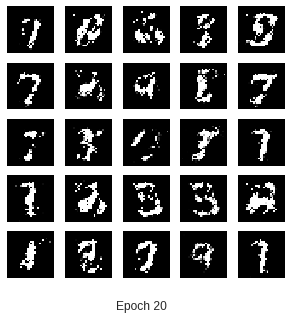

[21/100] - ptime: 7.38 loss_d: 1.025, loss_g: 1.280
[22/100] - ptime: 7.45 loss_d: 1.051, loss_g: 1.227
[23/100] - ptime: 7.33 loss_d: 1.079, loss_g: 1.175
[24/100] - ptime: 7.37 loss_d: 1.141, loss_g: 1.067
[25/100] - ptime: 7.33 loss_d: 1.158, loss_g: 1.026
[26/100] - ptime: 7.32 loss_d: 1.175, loss_g: 1.028
[27/100] - ptime: 7.48 loss_d: 1.175, loss_g: 0.991
[28/100] - ptime: 7.30 loss_d: 1.197, loss_g: 0.962
[29/100] - ptime: 7.33 loss_d: 1.214, loss_g: 0.918
[30/100] - ptime: 7.35 loss_d: 1.234, loss_g: 0.908
[31/100] - ptime: 7.35 loss_d: 1.249, loss_g: 0.870
[32/100] - ptime: 7.45 loss_d: 1.253, loss_g: 0.883
[33/100] - ptime: 7.36 loss_d: 1.222, loss_g: 0.918
[34/100] - ptime: 7.36 loss_d: 1.253, loss_g: 0.864
[35/100] - ptime: 7.26 loss_d: 1.258, loss_g: 0.854
[36/100] - ptime: 7.28 loss_d: 1.275, loss_g: 0.824
[37/100] - ptime: 7.39 loss_d: 1.266, loss_g: 0.849
[38/100] - ptime: 7.31 loss_d: 1.253, loss_g: 0.855
[39/100] - ptime: 7.33 loss_d: 1.273, loss_g: 0.818
[40/100] - p

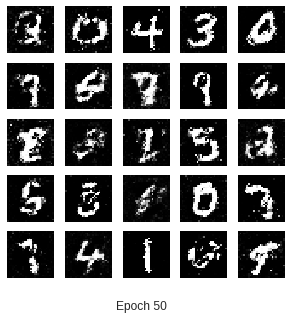

[51/100] - ptime: 7.39 loss_d: 1.291, loss_g: 0.787
[52/100] - ptime: 7.35 loss_d: 1.293, loss_g: 0.775
[53/100] - ptime: 7.28 loss_d: 1.297, loss_g: 0.778
[54/100] - ptime: 7.53 loss_d: 1.296, loss_g: 0.782
[55/100] - ptime: 7.34 loss_d: 1.291, loss_g: 0.783
[56/100] - ptime: 7.30 loss_d: 1.295, loss_g: 0.772
[57/100] - ptime: 7.29 loss_d: 1.294, loss_g: 0.784
[58/100] - ptime: 7.22 loss_d: 1.297, loss_g: 0.783
[59/100] - ptime: 7.32 loss_d: 1.291, loss_g: 0.787
[60/100] - ptime: 7.28 loss_d: 1.284, loss_g: 0.789
[61/100] - ptime: 7.39 loss_d: 1.291, loss_g: 0.790
[62/100] - ptime: 7.34 loss_d: 1.288, loss_g: 0.790
[63/100] - ptime: 7.32 loss_d: 1.291, loss_g: 0.775
[64/100] - ptime: 7.28 loss_d: 1.295, loss_g: 0.782
[65/100] - ptime: 7.36 loss_d: 1.304, loss_g: 0.761
[66/100] - ptime: 7.58 loss_d: 1.314, loss_g: 0.754
[67/100] - ptime: 7.28 loss_d: 1.300, loss_g: 0.772
[68/100] - ptime: 7.28 loss_d: 1.300, loss_g: 0.771
[69/100] - ptime: 7.34 loss_d: 1.300, loss_g: 0.764
[70/100] - p

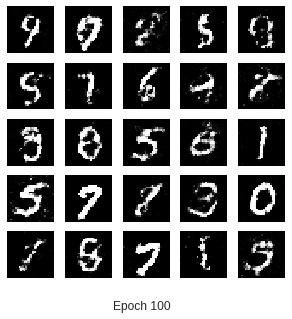

Avg per epoch ptime: 7.42, total 100 epochs ptime: 988.75


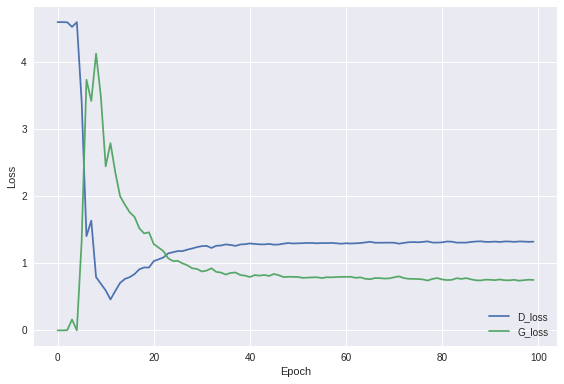

In [13]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
  
# training-loop
np.random.seed(int(time.time()))
start_time = time.time()
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    for iter in range(train_set.shape[0] // batch_size):
        # update discriminator
        x_ = train_set[iter*batch_size:(iter+1)*batch_size]
        z_ = np.random.normal(0, 1, (batch_size, 100))

        loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, z: z_, drop_out: 0.3})
        D_losses.append(loss_d_)

        # update generator
        z_ = np.random.normal(0, 1, (batch_size, 100))
        loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, drop_out: 0.3})
        G_losses.append(loss_g_)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))

    ### Save pictures to the Google Drive: goo.gl/kyr3tg
    p = 'MNIST_GAN_results/Random_results/MNIST_GAN_' + str(epoch + 1) + '.png'
    show_result((epoch + 1), folder_id = '1OolcTqMCwFHpZ0rfcT7KAWnQXkkYyzRW', name=p, isFix=False)
    
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
      
end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)
print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
with open('MNIST_GAN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)
show_train_hist(train_hist, show=True)
sess.close()